## Отчет по заданию 1 для стажеров 
_____________________
Выполнено Филимоновым Владиславом (ВМК МГУ 3-й курс).

## Задание 1.1 построение классификатора для распознавания крокодилов/часов
_____________
__Описание подхода к решению__:
В качестве классификатора была выбрана сверточная нейронная сеть с полносвязным слоем в конце (класс CNN в файле models.py). 


На этапе подбора параметров исходные данные были разделены на три части:
* обучающая выборка (80% датасета);
* валидационная выборка для подбора параметров (10% датасета)
* тестовая выборка для оценки качества построенной модели (10% датасета)

Сеть имела достаточно простую структуру в силу небольшого размера датасета:
1. Сверточный блок (сверточный слой + нелинейность + пулинг
2. Линейный блок ((дропаут + полносвязный слой) + нелинейность + полносвязный)

Подбор параметров производился следующим образом:
1) Фиксируется все гиперпараметры, кроме одного
2) Ищется по некоторой сетке (составлено мной) значение гиперпараметра, которое дает наибольшую точность на валидационной выборке.
3) Аналогично перебираются все гиперпараметры.

Файл с подбором параметров -  conv1.ipynb

Подобный подбор параметров не является оптимальным вариантом и гораздо лучше было бы использовать GridSearch, но данный метод требовал бы значительно больших временных затрат в силу большого числа гиперпараметров модели. Поэтому был выбран такой метод подбора параметров.

Полученные точности (их вычисление также в файле conv1.ipynb в самом низу):

 | train | validate | test
 ---|--- | --- | ---
 Accuracy(%)| 89.375|85.0|85.0

В ячейке ниже приведен код, который реализует обучение и предсказание. Необходимо вписать путь к папкам содержащим тестовую и обучающую выборку.

In [176]:
import models
import models
import numpy as np
from skimage.io import imread_collection
import torch
import glob
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from math import floor
import torch.optim as optim
from importlib import reload
from torch.autograd import Variable
reload(models)

<module 'models' from 'C:\\Users\\ifili\\MMP_MSU\\for samsung\\models.py'>

In [9]:
"""Insert way to training clocks and crocks"""
crocks = np.array(imread_collection(glob.glob("way_to_training_crocks/*.png")))
clocks = np.array(imread_collection(glob.glob("way_to_training_clocks/*.png")))
"""
for example
crocks = np.array(imread_collection(glob.glob("./clocks_crocodiles/crocodile/train/*.png")))
clocks = np.array(imread_collection(glob.glob("./clocks_crocodiles/clock/train/*.png")))
"""
data = np.concatenate((crocks, clocks), axis=0)
Y = np.zeros(data.shape[0], dtype=np.int)
Y[0:crocks.shape[0]] = 1
ind = np.random.permutation(data.shape[0])
data = data[ind, ...]
Y = Y[ind]
data = (data -127.5)/127.5
data = np.transpose(data, axes=(0,3,1,2))

In [10]:
"""
Insert way to testing clocks and crocks
"""
#crocks_test = np.array(imread_collection(glob.glob("way_to_testing_crocks/*.png")))
#clocks_test = np.array(imread_collection(glob.glob("way_to_testing_clocks/*.png")))

crocks_test = np.array(imread_collection(glob.glob("./clocks_crocodiles/crocodile/test/*.png")))
clocks_test = np.array(imread_collection(glob.glob("./clocks_crocodiles/clock/test/*.png")))

"""
for example
crocks_test = np.array(imread_collection(glob.glob("./clocks_crocodiles/crocodile/test/*.png")))
clocks_test = np.array(imread_collection(glob.glob("./clocks_crocodiles/clock/test/*.png")))
"""
data_test = np.concatenate((crocks_test, clocks_test), axis=0)
Y_test = np.zeros(data_test.shape[0], dtype=np.int)
Y_test[0:crocks_test.shape[0]] = 1
ind = np.random.permutation(data_test.shape[0])
data_test = data_test[ind, ...]
Y_test = Y_test[ind]
data_test = (data_test -127.5)/127.5
data_test = np.transpose(data_test, axes=(0,3,1,2))

In [11]:
train_set = torch.from_numpy(data)
train_y = torch.from_numpy(Y)
test_set = torch.from_numpy(data_test)
test_y = torch.from_numpy(Y_test)
train = torch.utils.data.TensorDataset(train_set, train_y)
test = torch.utils.data.TensorDataset(test_set, test_y)

In [19]:
bs = 4
trainloader = torch.utils.data.DataLoader(train, batch_size=bs,
                                         shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test, batch_size=bs,
                                         shuffle=True, num_workers=2)
l_conv = [nn.Conv2d(3, 15, kernel_size=2, stride=1),  nn.Tanh()]
l_class = [nn.Dropout(p=0.3),
           nn.Linear(15 *(31)*(31), 140),
            nn.ReLU(inplace=True),
            nn.Linear(140, 2)]
mod = models.CNN(l_conv, l_class, 15)
mod = mod.double()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mod.parameters(), lr=0.001, weight_decay=1e-3, momentum=0.9)
models.fit(mod, trainloader, criterion, optimizer)
print("Accuracy on test", models.calculate_accuracy(mod, testloader, criterion))

Accuracy on test 79.5


## Задание 1.2 Поиск крокодилов, похожих на часы и часов, похожих на крокодилов
___________________

Предлагается два подхода к  решению данной проблемы:
* Разбить датасет на две части (большую и маленькую) так, чтобы они не пересекались. Обучить классификатор на большой части, затем сделать предсказание на маленькой. Выбрать те объекты, которые классифицируются неверно, при этом классификатор уверен в своем ответе(например, для классификатора из 1.1: он возвращает два вещественных числа - уверенность в каждом классе, чем оно больше, тем больше уверенность. Можно взять softmax от выхода и интерпертировать его как вероятности классов. Объекты будем считать похожими, если классификатор ошибся на данном объекте и был уверен в своем ответе (вероятность > порога (например, 0.8))
* Обучить сверточный автокодировщик на всем датасете, затем посчитать центроид каждого класса, закодировать центроиды и все картинки с помощью кодировщика, затем в этом новом пространстве искать объекты одного классы близкие по метрике к объектам другого класса.

Идея первого метода прозрачна, а вот идею второго следует пояснить. Сверточный автокодировщик ищет такое представление картинки в пространстве меньшей размерности, чтобы по нему можно было максимально хорошо восстановить исходную картинку. Если вспомнить, что фильтры представимы в виде свертки, то можно предположить, что при обучении сверточного автокодировщика мы обучаем "фильтры". Эти фильтры выделяют более высокоуровневые признаки, как например фильтр собеля выделяет границу и тд. И объекты, которые имеют похожее признаковое описание после кодировщика, похожи как картинки.

## Первый подход

In [21]:
crocks = np.array(imread_collection(glob.glob("./clocks_crocodiles/crocodile/*.png")))
clocks = np.array(imread_collection(glob.glob("./clocks_crocodiles/clock/*.png")))
indexes = [x * 50 for x in(range(0,11))]

In [147]:
res_cr = 13 * np.ones((500, 4))
res_cl = 12 * np.ones((500, 4))
for i in range(1,11):
    tmp1 = crocks[indexes[i-1]:indexes[i],...]
    tmp2 = clocks[indexes[i-1]:indexes[i],...]
    train = np.concatenate((crocks[0:indexes[i-1],...], crocks[indexes[i]:, ...],
                           clocks[0:indexes[i-1],...], clocks[indexes[i]:, ...]), axis=0)
    test = np.concatenate((tmp1, tmp2), axis=0)
    train = (train - 127.5) / 127.5
    test = (test - 127.5) / 127.5
    train_y = np.concatenate((np.ones(450, dtype=np.int), np.zeros(450, dtype=np.int)), axis=0)
    test_y = np.concatenate((np.ones(50, dtype=np.int), np.zeros(50, dtype=np.int)), axis=0)
    train = np.transpose(train, axes=(0,3,1,2))
    test = np.transpose(test, axes=(0,3,1,2))
    train = torch.from_numpy(train)
    train_y = torch.from_numpy(train_y)
    test = torch.from_numpy(test)
    test_y = torch.from_numpy(test_y)
    train = torch.utils.data.TensorDataset(train, train_y)
    trainloader = torch.utils.data.DataLoader(train, batch_size=bs,
                                         shuffle=True, num_workers=2)
    l_conv = [nn.Conv2d(3, 15, kernel_size=2, stride=1),  nn.Tanh()]
    l_class = [nn.Dropout(p=0.3),
           nn.Linear(15 *(31)*(31), 140),
            nn.ReLU(inplace=True),
            nn.Linear(140, 2)]
    mod = models.CNN(l_conv, l_class, 15)
    #mod = mod.float()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(mod.parameters(), lr=0.001, weight_decay=1e-3, momentum=0.9)
    models.fit(mod, trainloader, criterion, optimizer, epoch=6)
    inputs, labels = Variable(test), test_y.long()
    outputs = mod(inputs.float())
    _, predicted = torch.max(outputs.data, 1)
    not_probs = outputs.data.numpy()
    predicted = predicted.numpy()
    labels = labels.numpy()
    tmp_res = np.concatenate((not_probs, predicted[:,np.newaxis], labels[:, np.newaxis]), axis=1)
    res_cr[indexes[i-1]:indexes[i],...] = tmp_res[0:50,...]
    res_cl[indexes[i-1]:indexes[i],...] = tmp_res[50:,...]

In [167]:
ind_crock = np.where(res_cr[:,2] != res_cr[:,3])[0]
ind_clock = np.where(res_cl[:,2] != res_cl[:,3])[0]
error_crock = res_cr[res_cr[:,2] != res_cr[:,3], :][:,0:2]
error_clock = res_cl[res_cl[:,2] != res_cl[:,3], :][:,0:2]
error_crock_p = np.exp(error_crock) 
error_clock_p = np.exp(error_clock)
error_crock_p /= error_crock_p.sum(axis=1)[:, np.newaxis]
error_clock_p /= error_clock_p.sum(axis=1)[:, np.newaxis]
ind_crock_2 = np.where(error_crock_p[:,0] > 0.95)[0]
ind_clock_2 = np.where(error_clock_p > 0.98)[0]
crock_to_show = ind_crock[ind_crock_2]
clock_to_show = ind_clock[ind_clock_2]
crock = crocks[crock_to_show,...]
clock = clocks[clock_to_show,...]

## Крокодилы похожие на часы

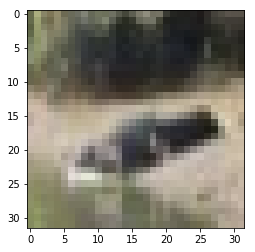

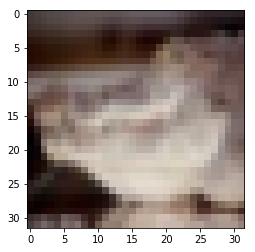

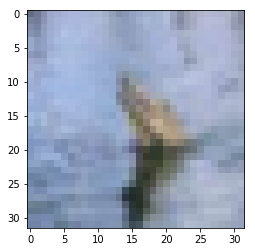

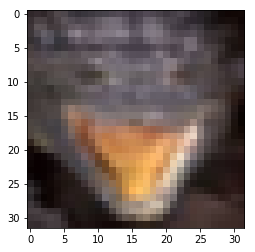

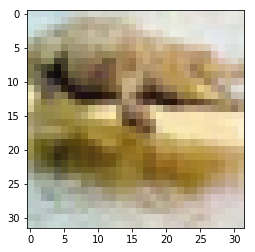

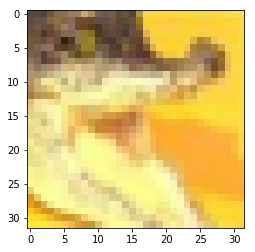

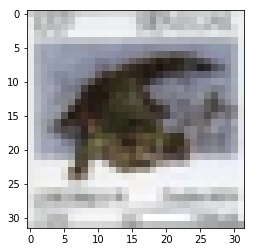

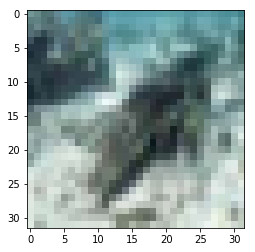

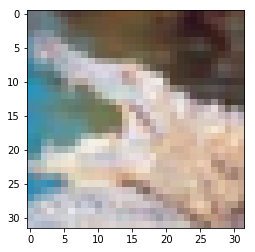

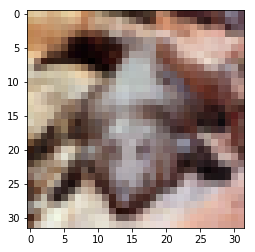

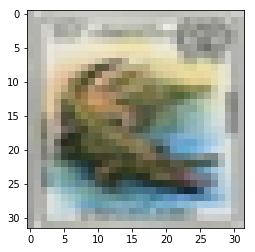

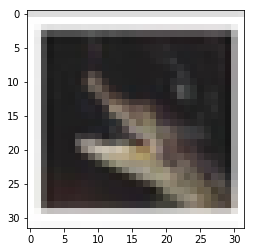

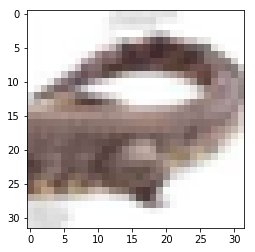

In [168]:
for c in range(0, crock.shape[0]):
    plt.imshow(crock[c,...])
    plt.show()

## Часы, похожие на крокодилов

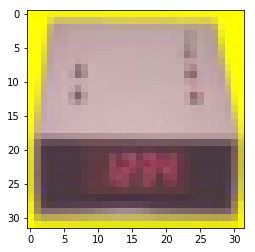

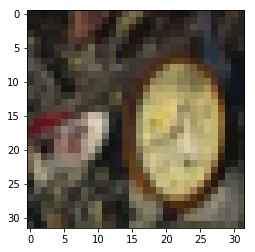

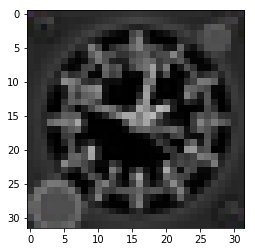

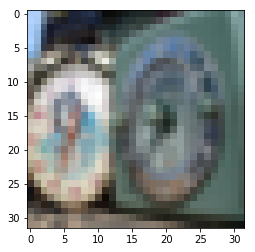

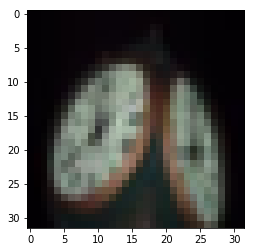

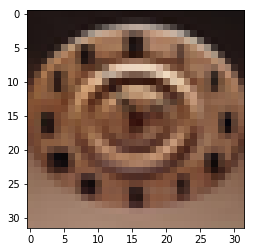

In [170]:
for c in range(0, clock.shape[0]):
    plt.imshow(clock[c,...])
    plt.show()

## Второй подход

Автокодировщик имеет следующую структуру:
1. Кодировщик( 2 сверточных блока( свертка + нелинейность + пулинг))
2. Декодировщик ( 2 блока(анпулинг + нелинейность + обратная свертка))

Реализован в файле models.py  - класс ConvAutoEnc (я когда-то делал его в рамках практикума, так что если вы увидите похожие прототипы у других людей, то это возможно мои одногруппники (прототипы выдавал проподаватель))


In [226]:
"""Insert way to training clocks and crocks"""
crocks = np.array(imread_collection(glob.glob("way_to_training_crocks/*.png")))
clocks = np.array(imread_collection(glob.glob("way_to_training_clocks/*.png")))
"""
for example
"""
crocks = np.array(imread_collection(glob.glob("./clocks_crocodiles/crocodile/*.png")))
clocks = np.array(imread_collection(glob.glob("./clocks_crocodiles/clock/*.png")))

data = np.concatenate((crocks, clocks), axis=0)
Y = np.zeros(data.shape[0], dtype=np.int)
Y[0:crocks.shape[0]] = 1
ind = np.random.permutation(data.shape[0])
data = data[ind, ...]
Y = Y[ind]
data = (data -127.5)/127.5
data = np.transpose(data, axes=(0,3,1,2))
train_set = torch.from_numpy(data)
train_y = torch.from_numpy(Y)
train = torch.utils.data.TensorDataset(train_set, train_y)
autoenc = models.ConvAutoEncoder(input_size=(3, 32, 32), layers_num=2, conv_out_channels=(35, 32),
                                  conv_kernel_size=(6, 6), conv_stride=(1,2),
                                  pool_kernel_size=(4, 4))
autoenc = autoenc.float()
criterion = nn.MSELoss()
optimizer = optim.SGD(autoenc.parameters(), lr=0.001, weight_decay=1e-3, momentum=0.9)

models.fit_autoenc(autoenc, train, optimizer, criterion, epoch=10)

(25.623011827468872, 0.17870503964275122)

In [229]:

mean_crock = torch.from_numpy(np.transpose((crocks.mean(axis=0) - 127.5)/127.5,axes=(2,1,0))[np.newaxis,...])
mean_clock = torch.from_numpy(np.transpose((clock.mean(axis=0) - 127.5)/127.5,axes=(2,1,0))[np.newaxis,...])
mc_crock = autoenc(Variable(mean_crock.float()) ,decode=False).data.numpy()
mc_clock = autoenc(Variable(mean_clock.float()) ,decode=False).data.numpy()
clocks_only = torch.from_numpy(np.transpose((clocks -127.5)/127.5, axes=(0,3,1,2)))
crocks_only = torch.from_numpy(np.transpose((crocks -127.5)/127.5, axes=(0,3,1,2)))
c_crocks = autoenc(Variable(clocks_only.float()) ,decode=False).data.numpy()
c_clocks = autoenc(Variable(crocks_only.float()) ,decode=False).data.numpy()

In [241]:
from scipy.spatial.distance import correlation
dist_cor_crocks = np.zeros(500)
dist_cor_clocks = np.zeros(500)
for i in range(500):
    dist_cor_crocks[i] = correlation(mc_clock.ravel(), c_crocks[i].ravel())
    dist_cor_clocks[i] = correlation(mc_crock.ravel(), c_clocks[i].ravel())    

In [242]:
ind_crock_2 = np.argsort(dist_cor_crocks)[0:5]
ind_clock_2 = np.argsort(dist_cor_clocks)[0:5]
crock = crocks[ind_crock_2,...]
clock = clocks[ind_clock_2,...]

## Крокодилы похожие на часы

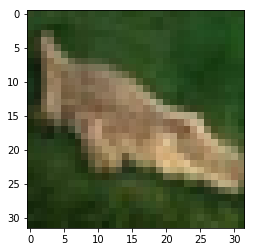

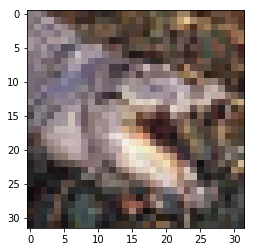

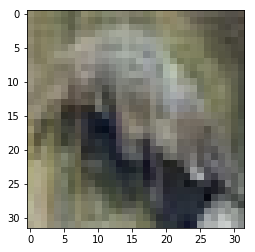

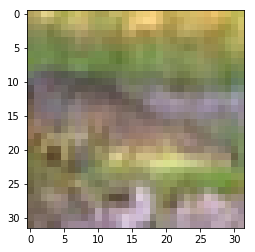

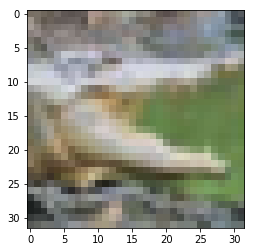

In [243]:
for c in range(0, crock.shape[0]):
    plt.imshow(crock[c,...])
    plt.show()

## Часы похожие на крокодилов

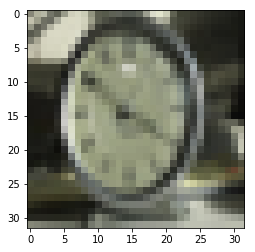

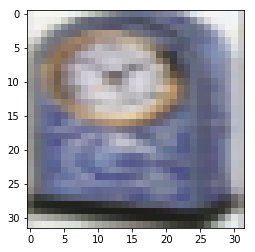

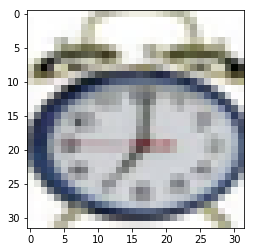

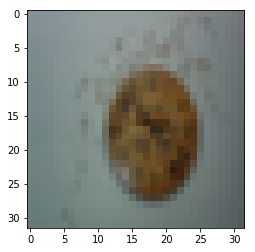

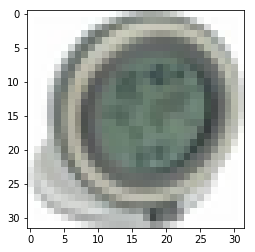

In [244]:
for c in range(0, clock.shape[0]):
    plt.imshow(clock[c,...])
    plt.show()

0.8612811118364334